### THU THẬP DỮ LIỆU STEAM MARKET 
### Nguồn dữ liệu : steamcommunity market (https://steamcommunity.com/market/)



### 1. Chuẩn bị tài nguyên :

Import các thư viện phục vụ thu thập & tiền xử lý dữ liệu

In [4]:
import requests 
import json 
import sys

import pandas as pd 
import numpy as np 

import datetime  
import time 
import random 

import warnings
from IPython.display import Image
warnings.filterwarnings(action = 'ignore', category = FutureWarning) 

Vì một vài request tới market của steam yêu cầu phải có thông tin tài khoản (login credentials) của người thu thập dữ liệu, nên ta cần chuẩn bị nó.
1. chọn biểu tượng ổ khóa ở trái thanh URL -> chọn Cookies -> chọn steamcommunity.com -> chọn Cookies -> chọn steamLoginSecure -> copy Nội dung sẽ là cookie cần dùng và bỏ vào dict cookie
(Vì mỗi lần đóng/mở trang sẽ cấp 1 cookie khác nên có thể cookie trong ảnh và cookie trong code sẽ khác nhau)

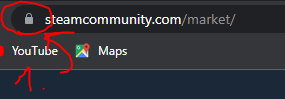  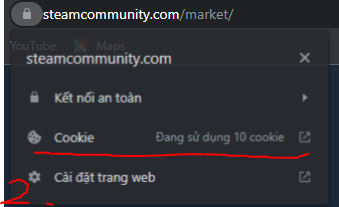!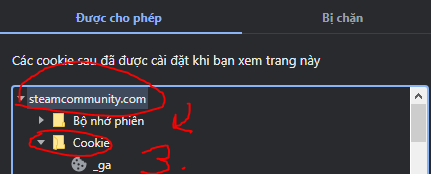 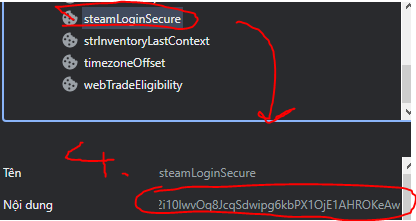

In [12]:
steamLoginSecure = '76561198329918048%7C%7CeyAidHlwIjogIkpXVCIsICJhbGciOiAiRWREU0EiIH0.eyAiaXNzIjogInI6MEJGQ18yMTgyMTQ5N182MjQwNCIsICJzdWIiOiAiNzY1NjExOTgzMjk5MTgwNDgiLCAiYXVkIjogWyAid2ViIiBdLCAiZXhwIjogMTY2OTc5ODQwNiwgIm5iZiI6IDE2NjEwNzA2MTIsICJpYXQiOiAxNjY5NzEwNjEyLCAianRpIjogIjBDNjRfMjFBRUM5NTBfQUU4MEUiLCAib2F0IjogMTY2NzAxMTc3NywgInJ0X2V4cCI6IDE2ODQ4NzY5NzUsICJwZXIiOiAwLCAiaXBfc3ViamVjdCI6ICIxMjUuMjM1LjIzOS4xNyIsICJpcF9jb25maXJtZXIiOiAiMTI1LjIzNS4yMzkuMTciIH0.4Yo3Ur2HcAw2FplCBgiWiaehPrpqVcelCa0WUxLEQImcDsyPC3Xi-KLenMG7CWjn-oVQb7dJclU8b5I6e3yoAQ'
cookie = {'steamLoginSecure': steamLoginSecure}

Đầu tiên thu thập số lượng skins có trên market và lưu vào biến total_Items

Giải thích 1 vài thuộc tính URL : 

        start - vị trí bắt đầu requests 
        count - số lượng skins cho 1 requests
        appid - 730 là id game của CSGO

In [13]:
URL = 'https://steamcommunity.com/market/search/render/?query=&start=0&count=100&search_descriptions=0&sort_column=price&sort_dir=desc&appid=730&norender=1'
Items_get = requests.get(url = URL, cookies = cookie)
Items = json.loads(Items_get.text)

data = Items['results']
total_Items = Items['total_count']


In [14]:
print(total_Items)

19089


Chuẩn bị Items_lists là danh sách chứa dữ liệu raw của tất cả skins

In [15]:
Items_list = []

Tiếp theo ta sẽ thu thập dữ liệu của toàn bộ skins tồn tại trên market.

Steam giới hạn mỗi lần chỉ được request tối đa 100 vật phẩm và tối đa 20 requests/phút. Việc thu thập dữ liệu cho phần này kéo dài khoảng ~50 phút.

In [ ]:
# get all items information, because steam only allow 100 items/request, and ~20 requests/minute so everytime request return code 400, put to sleep for 70 seconds
pos = 0
while (pos < total_Items) :
    while (True) :
        URL = 'https://steamcommunity.com/market/search/render/?query=&start=' + str(pos) + '&count=100&search_descriptions=0&sort_column=price&sort_dir=desc&appid=730&norender=1'
        Items_get = requests.get(url = URL, cookies = cookie)
        if(Items_get.status_code != 200) :
            time.sleep(70)
            break
        
        Items = json.loads(Items_get.text)
        data = Items['results']
        for item in data :
            Items_list.append(item['asset_description'])
            
        pos += 100

Chuẩn bị các hàm trích xuất giá trị của từng cột thuộc tính

In [ ]:
Item_extra_list = ['StatTrak™', 'Souvenir', 'Normal']

Item_type_list = ['Rifle', 'Sniper Rifle', 'Pistol', 'SMG', 'Shotgun', 'Machinegun', 
                  'Knife', 'Gloves', 'Sticker', 'Container', 'Others']

Exterior_list = ['Battle-Scarred', 'Well-Worn', 'Field-Tested', 'Minimal Wear', 'Factory New', 'None']

Rarity_list = ['Base Grade', 'Consumer Grade', 'Industrial Grade', 'Mil-Spec', 'Restricted', 
               'Classified', 'Covert', 'Extraordinary',
                  'High Grade', 'Remarkable', 'Exotic', 'None']

def _get_type(item_info) :                # get type of an item
    for cur_type in Item_type_list :
        if (item_info.find(cur_type) != -1) : return cur_type
    
    return Item_type_list[-1]

def _get_extra(item_info) :              # get extra status of an item
    for cur_extra in Item_extra_list :
        if (item_info.find(cur_extra) != -1) : return cur_extra
    
    return Item_extra_list[-1]

def _get_rarity(item_info) :              # get rarity of an item
    for cur_rarity in Rarity_list :
        if (item_info.find(cur_rarity) != -1) : return cur_rarity
    
    return Rarity_list[-1]

def _get_exterior(item_description) :     # get exterior of an item
    for cur_exterior in Exterior_list :
        if (item_description.find(cur_exterior) != -1) : return cur_exterior
    
    return Exterior_list[-1]



Format URL theo dạng chuẩn ASCII, phục vụ việc thu thập dữ liệu lịch sử giá của từng skin

In [ ]:
def _format_ASCII_Name(name) :            # format special characters into ASCII letter
    format_name = ''
    for ch in name :
        if (ch == '|')   : ch = '%7C'
        elif (ch == '&') : ch = '%26'
        elif (ch == ':') : ch = '%3A'
        elif (ch == '/') : ch = '%2F'
        elif (ch == '+') : ch = '%2B'
        elif (ch == ' ') : ch = '%20'
        elif (ch == '(') : ch = '%28'
        elif (ch == ')') : ch = '%29'
        
        format_name += ch
            
    return format_name

Hàm gửi request lấy giá của item

In [ ]:
def _get_price_request(name) :        # get price data from a skin
    while (True) :
        URL             = 'http://steamcommunity.com/market/pricehistory/?country=PT&currency=3&appid=730&market_hash_name=' + format_name
        item_price_data = requests.get(url = URL, cookies = cookie);
        if (item_price_data.status_code != 200) :
            #print(name, item_price_data.status_code)
            continue
            
        return json.loads(item_price_data.text)
        

Công đoạn tiền xử lý dữ liệu và thu thập dữ liệu về giá của từng vật phẩm. 

In [ ]:
items_df = pd.DataFrame(data = None, index = None, columns = ['Name', 'Type', 'Exterior', 'Rarity', 'Extra', 'Average volume sale',
                                                              'Average price (VND)', 'Max price (VND)', 'Days to reach max', 
                                                              'Min price (VND)', 'Days to reach min', 'Price change (%)',
                                                                  'Time on market (days)'])

cnt = 0
for cur_item in Items_list :        # Loop through each item in Item_list
    item_name        = cur_item['market_hash_name']           # Lấy tên vật phẩm
    item_info        = cur_item['type']                       # Lấy đoạn string chứa các thông tin rarity, extra, type
    item_description = cur_item['descriptions'][0]['value']   # Lấy đoạn string chứa thông tin exterior
    
    item_exterior = _get_exterior(item_description)     # Lấy exterior
    item_rarity   = _get_rarity(item_info)              # Lấy rarity
    item_extra    = _get_extra(item_info)               # Lấy extra
    item_type     = _get_type(item_info)                # Lấy type
    
    format_name     = _format_ASCII_Name(item_name)     # format tên item theo chuẩn ASCII
    item_price_data = _get_price_request(format_name)   # gửi request để lấy dữ liệu giá
    
    if (item_price_data) :                              # Kiểm tra ta có lấy được thông tin vật phẩm thì tiến hành tiền xử lý thông tin giá vật phẩm
        item_prices = item_price_data['prices']         
        success = item_price_data['success']
        if (item_prices == '') | (not item_prices) | (success == False) : continue
        
        price_list  = []            # Chứa giá bán của từng ngày
        vol_list    = []            # Chứa số lượng bán của từng ngày
        dates       = []            # Chứa các ngày
        
        tmp_price_list = []         # temp price list
        tmp_vol_list   = []         # temp vol list
        
        last_date = datetime.date(1, 1, 1) 
        
        l, r = 0, 0
        
        # There could be data of multiple sales of the same day
        # So we calculate price for a day is the average of all price sale in that day, using tmp_price_list
        # same for vol_list

        # Tồn tại dữ liệu giá item của nhiều khung giờ trong cùng 1 ngày
        # Nên ta sẽ tính trung bình giá của tất cả khung giờ trong ngày đó
        # Tương tự với số lượng item được bán
        
        # tmp_price_list, tmp_vol_list sẽ chứa giá / SL  riêng biệt (các khung giờ trong 1 ngày cũng sẽ tính là riêng)
        # price_list, tmp_list chỉ chứa giá / SL của từng ngày 
#         print(cnt, item_name)
#         cnt += 1
        
        while (r <= len(item_prices)) :
            cur_date = datetime.date(1, 1, 1)
            if (r < len(item_prices)) :            # still in list's boundary
                cur_date = datetime.datetime.strptime(item_prices[r][0][0 : 11], '%b %d %Y').date()
                
            if (cur_date != last_date and r != 0) :
                avg_price = np.mean(tmp_price_list[l : r])    # tính giá trung bình trong ngày last_date
                avg_vol   = np.mean(tmp_vol_list[l : r])      # tính số lượng bán trung bình trong ngày last_date
                
                price_list.append(avg_price)
                vol_list.append(avg_vol)
                dates.append(last_date)
                
                l = r
            
            if (r < len(item_prices)) : 
                tmp_price_list.append(item_prices[r][1])
                tmp_vol_list.append(float(item_prices[r][2]))
            
            
            last_date = cur_date
            r += 1
        
        avg_price = np.mean(price_list)           # tính giá trung bình của vật phẩm
        avg_vol   = np.mean(vol_list)             # tính số lượng bán trung bình của vật phẩm
        
        max_price = max(price_list)           # tính giá max
        min_price = min(price_list)           # tính giá min
        
        max_idx     = price_list.index(max_price)
        days_to_max = (dates[max_idx] - dates[0]).days   # tính số lượng ngày để đạt max
        
        min_idx     = price_list.index(min_price)
        days_to_min = (dates[min_idx] - dates[0]).days   # tính số luọngw ngày để đạt min
        
        if (price_list[0] == 0) : price_list[0] = 1
        price_change = (price_list[-1] - price_list[0]) / price_list[0]       # tính tỉ lệ biến động vật phẩm từ ngày xuất hiện đến hiện tại
        price_change = round(price_change, 2)
                                  
        time_on_market   = (dates[-1] - dates[0]).days           # tính số ngày vật phẩm đã tồn tại
        
        item_dict = {'Name' : item_name, 'Type' : item_type, 'Exterior' : item_exterior, 'Rarity' : item_rarity,
                      'Extra' : item_extra, 'Average volume sale' : avg_vol, 'Average price (VND)' : avg_price,
                        'Max price (VND)' : max_price, 'Days to reach max' : days_to_max,  'Min price (VND)' : min_price, 
                         'Days to reach min' : days_to_min, 'Price change (%)' : price_change, 'Time on market (days)' : time_on_market}
        
        cur_item_df = pd.DataFrame(item_dict, index = [0])
        items_df    = items_df.append(cur_item_df, ignore_index = True)     # Bỏ vào dataframe items_df
  

#items_df    

Xuất ra file CSV

In [ ]:
items_df.to_csv('CSGO_Market.csv', index = False)

In [ ]:
#tmp_df = pd.read_csv('CSGO_Market.csv')
#tmp_df